In [54]:
import os

os.chdir('/opt/ml/P-Stage/1-STAGE/')

from PIL import Image

import wandb
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
)

from config import get_args
from prepare import get_dataloader, get_classes, get_album_transforms
from metrics import (
    change_2d_to_1d,
    tensor_to_numpy,
    calculate_18class,
    tensor_images_to_numpy_images,
)


from log_helper import (
    log_f1_and_acc_scores,
    log_confusion_matrix,
    log_confusion_matrix_by_images,
)

def validation_test(models, dataloader, num_class=3):
    labels = np.empty((len(dataloader.dataset)))
    ensemble_results = np.empty((len(dataloader.dataset), num_class))
    
    for model in models:
        model = torch.load(model)
    
        for idx, (image, label) in enumerate(dataloader):
            image, label = image.cuda(), label.cuda()
            bs = image.shape[0]
        
            preds = model(image)
            
            labels[idx*bs:(idx+1)*bs] = tensor_to_numpy(label)
            ensemble_results[idx*bs:(idx+1)*bs] += tensor_to_numpy(torch.softmax(preds, dim=1))
            
            print(idx, end="\r")
    
    return ensemble_results, labels

In [2]:
args = get_args()
args

Namespace(age_model='/opt/ml/weights/age.pt', aug_keys='CJ,FancyPCA', batch_size=64, data_dir='/opt/ml/input/data/train', epochs=25, eval=True, gender_model='/opt/ml/weights/gender.pt', image_size=224, inf_filename='valid', loss_metric='f1_loss', lr=0.001, mask_model='/opt/ml/weights/mask.pt', model_path='/opt/ml/weights/', model_save=True, optimizer='adam', seed=42, test=True, train_key='mask', use_only_mask=False, valid_size=0.5, workers=2)

## Age Ensemble Test

In [16]:
age_models = [
    'age-04070152-easy-sweep-6',
    'age-04070047-driven-sweep-5',
    'age-04062341-magic-sweep-4',
    'age-04062055-still-sweep-1'
]

age_models = list(map(lambda x: os.path.join('/opt/ml/weights/', x) + ".pt", age_models))
age_models

['/opt/ml/weights/age-04070152-easy-sweep-6.pt',
 '/opt/ml/weights/age-04070047-driven-sweep-5.pt',
 '/opt/ml/weights/age-04062341-magic-sweep-4.pt',
 '/opt/ml/weights/age-04062055-still-sweep-1.pt']

In [17]:
args.train_key = "age"
args.valid_size = 0.15
args.test = False

_, dataloader = get_dataloader(args)
print(len(dataloader.dataset))

In [21]:
preds, labels = validation_test(age_models, dataloader, 3)
labels = labels.astype(np.int)

### 첫 번째 Age Ensemble

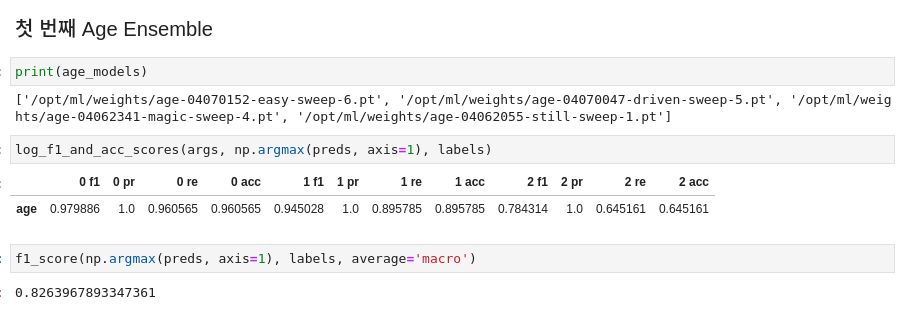

In [25]:
print(age_models)

['/opt/ml/weights/age-04070152-easy-sweep-6.pt', '/opt/ml/weights/age-04070047-driven-sweep-5.pt', '/opt/ml/weights/age-04062341-magic-sweep-4.pt', '/opt/ml/weights/age-04062055-still-sweep-1.pt']


In [22]:
log_f1_and_acc_scores(args, np.argmax(preds, axis=1), labels)

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
age,0.979886,1.0,0.960565,0.960565,0.945028,1.0,0.895785,0.895785,0.784314,1.0,0.645161,0.645161


In [23]:
f1_score(np.argmax(preds, axis=1), labels, average='macro')

0.8263967893347361

## Mask Ensemble Test

In [32]:
mask_models = [
    'mask-04050759-absurd-sweep-4', # 7
    'mask-04050847-devout-sweep-5', # 8
    'mask-04051102-copper-sweep-9', # 8
    'mask-04051658-rich-sweep-17', # 8
]

mask_models = list(map(lambda x: os.path.join('/opt/ml/weights/', x) + ".pt", mask_models))
mask_models

['/opt/ml/weights/mask-04050759-absurd-sweep-4.pt',
 '/opt/ml/weights/mask-04050847-devout-sweep-5.pt',
 '/opt/ml/weights/mask-04051102-copper-sweep-9.pt',
 '/opt/ml/weights/mask-04051658-rich-sweep-17.pt']

In [33]:
args.train_key = "mask"
args.valid_size = 0.2
args.test = False

_, dataloader = get_dataloader(args)
print(len(dataloader.dataset))

3780


In [34]:
preds, labels = validation_test(mask_models, dataloader, 3)
labels = labels.astype(np.int)

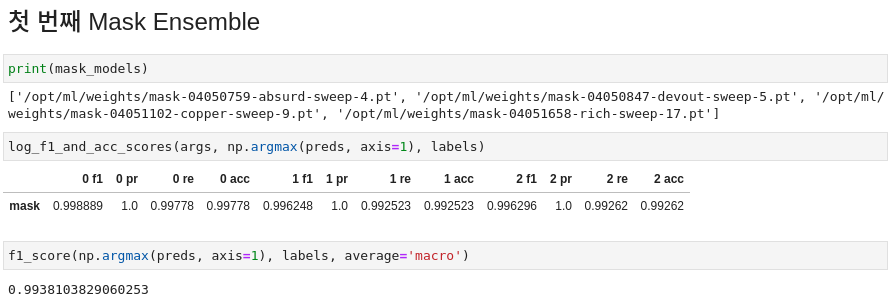

## 첫 번째 Mask Ensemble

In [35]:
print(mask_models)

['/opt/ml/weights/mask-04050759-absurd-sweep-4.pt', '/opt/ml/weights/mask-04050847-devout-sweep-5.pt', '/opt/ml/weights/mask-04051102-copper-sweep-9.pt', '/opt/ml/weights/mask-04051658-rich-sweep-17.pt']


In [36]:
log_f1_and_acc_scores(args, np.argmax(preds, axis=1), labels)

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,0.998889,1.0,0.99778,0.99778,0.996248,1.0,0.992523,0.992523,0.996296,1.0,0.99262,0.99262


In [37]:
f1_score(np.argmax(preds, axis=1), labels, average='macro')

0.9938103829060253

## Gender Ensemble Test

In [46]:
gender_models = [
    'gender-04052055-still-sweep-14', # 38
]

gender_models = list(map(lambda x: os.path.join('/opt/ml/weights/', x) + ".pt", gender_models))
gender_models

['/opt/ml/weights/gender-04052055-still-sweep-14.pt']

In [47]:
args.train_key = "gender"
args.valid_size = 0.2
args.test = False

_, dataloader = get_dataloader(args)
print(len(dataloader.dataset))

3780


In [ ]:
preds, labels = validation_test(gender_models, dataloader, 2)
labels = labels.astype(np.int)

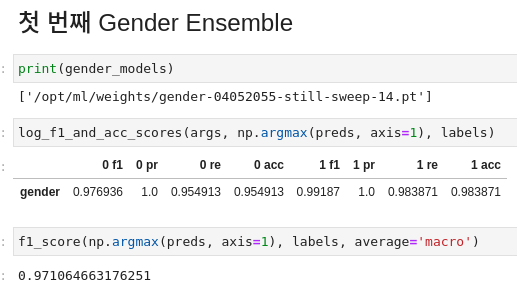

## 첫 번째 Gender Ensemble

In [49]:
print(gender_models)

['/opt/ml/weights/gender-04052055-still-sweep-14.pt']


In [50]:
log_f1_and_acc_scores(args, np.argmax(preds, axis=1), labels)

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc
gender,0.976936,1.0,0.954913,0.954913,0.99187,1.0,0.983871,0.983871


In [51]:
f1_score(np.argmax(preds, axis=1), labels, average='macro')

0.971064663176251

## Ensemble EVAL

In [87]:
train_df = pd.read_csv('/opt/ml/inp)

SyntaxError: EOL while scanning string literal (<ipython-input-87-0d01f24d8a45>, line 1)

In [52]:
test_df = pd.read_csv('/opt/ml/input/data/eval/info.csv')
image_path = test_df["ImageID"].apply(lambda x: os.path.join("/opt/ml/input/data/eval/images/", x))

In [53]:
test_df.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [85]:
def ensemble_results(models, transform, num_class=3):
    test_df = pd.read_csv('/opt/ml/input/data/eval/info.csv')
    image_pathes = test_df["ImageID"].apply(lambda x: os.path.join("/opt/ml/input/data/eval/images/", x))
    
    # print(len(test_df), len(image_pathes))
    
    ensemble_results = np.empty((len(test_df), num_class))
    
    for model in models:
        model = torch.load(model)
        
        for idx, image_full_path in enumerate(image_pathes):
        
            image = np.array(Image.open(image_full_path))
            image = transform(image=image)['image']
            image = np.transpose(image, axes=(2, 0, 1))
            image = torch.tensor(image).cuda().unsqueeze(0)
            
            preds = model(image)
            ensemble_results[idx] += tensor_to_numpy(torch.softmax(preds[0], dim=0))
            
            print(idx, end='\r')
    
    return ensemble_results

In [86]:
results = dict()

for ke/opt/ml/input/n zip(["age", "mask", "gender"], [age_models, mask_models[:1], gender_models[:1]]):
    
    args.train_key = key
    num_class = len(get_classes(args))
    _, transform = get_album_transforms(args)
    
    e_results = ensemble_results(models, transform, num_class)
    results[key] = e_results

In [88]:
results.keys()

dict_keys(['age', 'mask', 'gender'])

In [89]:
results["age"]

array([[2.40769233e-002, 2.38698074e+000, 1.58894224e+000],
       [7.42887736e-004, 1.72548079e+000, 5.29173457e+174],
       [1.07504429e-002, 4.03241966e+175, 1.45094206e+165],
       ...,
       [3.90758890e+000, 9.24026179e-002, 8.53714772e-006],
       [2.87383316e-002, 3.95292193e+000, 1.83398458e-002],
       [4.91724099e-003, 1.03729321e+000, 2.95778960e+000]])

In [58]:
np.argmax(results["age"], axis=1)

array([1, 2, 1, ..., 0, 1, 2])

In [90]:
results["age"] = np.argmax(results["age"], axis=1)
results["mask"] = np.argmax(results["mask"], axis=1)
results["gender"] = np.argmax(results["gender"], axis=1)

## 어떻게 예측하나 보자

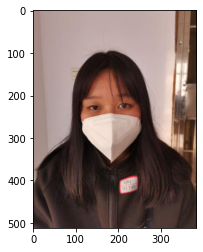

In [80]:
plt.imshow(pil_img)

In [82]:
axes.shape

(10,)

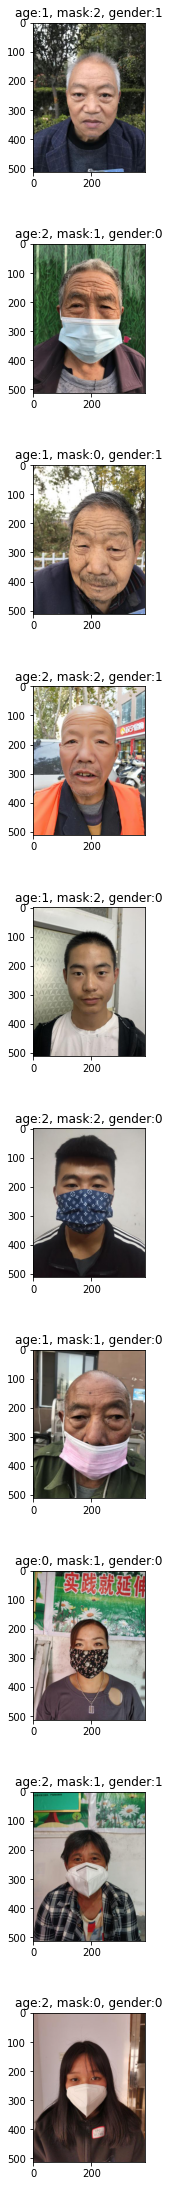

In [84]:
import time
from PIL import Image

test_df = pd.read_csv('/opt/ml/input/data/eval/info.csv')
image_pathes = test_df["ImageID"].apply(lambda x: os.path.join("/opt/ml/input/data/eval/images/", x))

fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(2, 40))

for idx, image_full_path in enumerate(image_pathes[:10]):
    pil_img = Image.open(image_full_path)
    axes[idx].imshow(pil_img)
    axes[idx].set_title(f"age:{age_results[idx]}, mask:{mask_results[idx]}, gender:{gender_results[idx]}")

In [68]:
results

{'age': array([1, 2, 1, ..., 0, 1, 2]),
 'mask': array([2, 1, 0, ..., 2, 1, 0]),
 'gender': array([1, 0, 1, ..., 1, 1, 0])}

## Final Result..

하.. 의미 없다

In [91]:
test_df = pd.read_csv('/opt/ml/input/data/eval/info.csv')

age_results = results["age"]
mask_results = results["mask"]
gender_results = results["gender"]

for idx, (mi, gi, ai) in enumerate(zip(mask_results, gender_results, age_results)):
    res = calculate_18class(mi, gi, ai)
    test_df.iloc[idx, 1] = res

In [92]:
test_df.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,16
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,7
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,4
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,2


## Save Model ( 이름 수정 !! )

In [93]:
# age: 1, mask: 1, gender: 1
file_name = "ensemble-002.csv"

test_df.to_csv(os.path.join("/opt/ml/P-Stage/1-STAGE/submissions/", file_name), index=False)